# Decoding — The CpG Island Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import hmm

np.random.seed(0) #set random seed

We can decode hidden states of a sequence given a Hidden Markov Model of the process that generated it. To define an HMM we need the following:

1. A matrix of transition probabilities from one state to another
2. A matrix of emission probabilities in each state
3. Initial probabilities of being in a state

For our problem we are dealing with two states — `+` and `-` where `+` indicates a CpG island and `-` indicates a non-CpG island.
In each state, the markov model can emit one of four nucleotide bases — `A`, `T`, `G` or `C`.

# A Simple HMM for CpG Islands

We start with a simple HMM for decoding CpG islands. This HMM is similar to a dishonest casino model.

In [2]:
transition = pd.read_csv("cpg_hmm_1/transition.csv",index_col=0)
emission = pd.read_csv("cpg_hmm_1/emission.csv",index_col=0)
init = pd.read_csv("cpg_hmm_1/init.csv",index_col=0)

### 1. Transition Matrix

In [3]:
transition

,-,+
-,0.95,0.05
+,0.10,0.90


### 2. Emission Matrix

In [4]:
emission

,A,C,T,G
-,0.27,0.24,0.26,0.23
+,0.15,0.33,0.16,0.36


### 3. Initial Probabilities

In [5]:
init

,-,+
p,0.5,0.5


## Constructing a sequence under this HMM
Let's construct a DNA sequence under the HMM with 10 base pairs.

In [6]:
N = 10 #number of bases

In [7]:
seq = np.zeros(N,dtype='object')
st = np.zeros(N+1,dtype='object')
st[0] = np.random.choice(list(init.columns), 1, p=list(init.iloc[0]))[0]
for i in range(N):
    seq[i] = np.random.choice(list(emission.columns), 1, p=list(emission.loc[st[i]]))[0]
    st[i+1] = np.random.choice(list(transition.columns), 1, p=list(transition.loc[st[i]]))[0]
st = np.delete(st, -1)

In [8]:
print(np.sum(st))
print(np.sum(seq))

+++++++---
GTGGCTGAGG


Note that there are more CG bases in the `+` state.

## Decoding hidden states with Viterbi Algorithm

Construct a viterbi matrix ($V$) of size *k* x *N* where *k* is the number of states and *N* is the number of sequence elements. We will also need a `tracer` matrix of size *k* x *N*.

In [9]:
k = np.shape(emission)[0]
V = np.zeros([k,N]) #viterbi matrix
tracer = np.zeros([k,N],dtype='object')

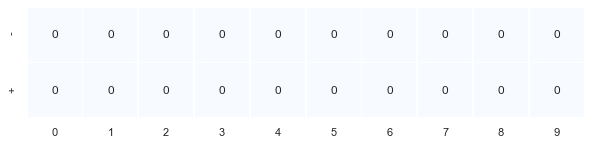

In [10]:
plt.figure(figsize=(10,5))
sns.heatmap(V,square=True,cbar=False,linewidth = 1,yticklabels=list(transition.columns),cmap='Blues',annot=True);

### Initialization
The first column (*j*=1) is filled with the initial probabilities of being in the *i*th state multiplied by the emission probability associated with that state and the 1st sequence element.

In [11]:
V[:,0] = init*emission[seq[0]]

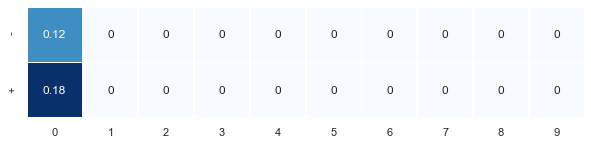

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(V,square=True,cbar=False,linewidth = 1,yticklabels=list(transition.columns),cmap='Blues',annot=True);

*Note*: We fill up the matrix with log values and after that is complete, we exponentiate all values. This is done to prevent overflow.

In [13]:
V[:,0] = np.log(V[:,0])

### Fill Step

To fill up the matrix we use the relation:

$V_{i,j} = max_k \big\{ V_{k,j-1} \times P(\pi_i|\pi_k) \times P(x_j|\pi_i) \big\} $

where $P(\pi_i|\pi_k)$ is the transition probability of going from state $\pi_k$ to state $\pi_i$ and $P(x_j|\pi_i)$ is the emission probability of emitting the base $x_j$ in the state $\pi_i$.

In [14]:
for j in range(1,N):
    for i in range(0,k):
        possibles = V[:,j-1]+np.log(transition.iloc[:,i])+np.log(emission[seq[j]][i])
        V[i,j] = np.max(possibles)
        tracer[i,j-1] = (np.array(transition.columns[np.where(possibles==np.max(possibles))])[0])
V = np.exp(V)

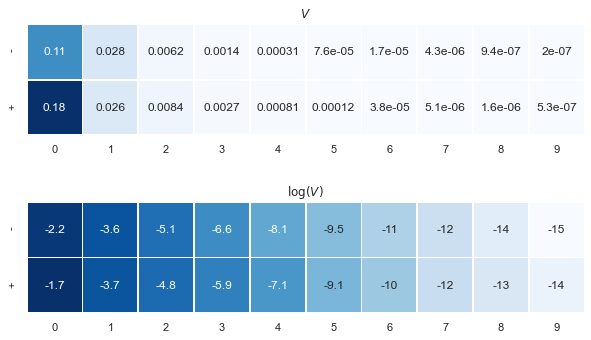

In [15]:
fig,ax = plt.subplots(2,1,figsize=(10,6))
sns.heatmap(V,square=True,cbar=False,linewidth = 1,cmap='Blues',
            yticklabels=list(transition.columns),annot=True,ax=ax[0])
ax[0].set_title("$V$")
sns.heatmap(np.log(V),square=True,cbar=False,linewidth = 1,
            cmap='Blues',yticklabels=list(transition.columns),annot=True,ax=ax[1])
ax[1].set_title("$\log(V)$");

In [16]:
tracer[k-1,N-1] = np.array(transition.columns[np.where(V[:,N-1]==np.max(V[:,N-1]))])[0] #final traceback
tracer[tracer==0] = '/' #ignoring all elements of the last column except the maximum one

### Traceback

Let's visualize the tracer matrix.

In [17]:
pd.DataFrame(tracer)

,0,1,2,3,4,5,6,7,8,9
0,-,-,-,-,-,-,-,-,-,/
1,+,+,+,+,+,+,+,+,+,+


The tracer matrix indicates the traceback directions for each element of the $V$ matrix. We start with the element in the last row and the last column. It tells us the state of the final element. 

If the final element is in the `+` state, we move towards the left (and diagonally if `-`). Now we note that the state of the second last element. In this manner, we follow the symbols as we traceback. Unlike in sequence alignment, the likelihood of multiple tracebacks is rare.

In [18]:
st = np.zeros(N,dtype='object')
st[-1] = tracer[-1,-1]
for i in range(2,N+1):
    st[-i] = tracer[(np.where(np.array(transition.columns)==st[-i+1])[0][0]),-i]

In [19]:
print(np.sum(st))
print(np.sum(seq))

++++++++++
GTGGCTGAGG


The Viterbi Algorithm might not spit out the precise states that generated our sequence. It attempts to estimate them but does not always succeed.

## Finding CpG islands in larger sequences

We will use the functions `hmm.generate` to create sequences according to an HMM (defined by the `transition`, `emission` and `init` matrices) and the function `hmm.viterbi` to decode the hidden states.

In [20]:
st,seq = hmm.generate(transition, emission, init, 100)
print(st)
print(seq)

+++++++++++------------------------------++++++++++++++++++++++++++++-------------------------------
CAATCCATGCGTACTGATCATAGGGGTCCCATTTCACTGTTCTCCGGGGGGCAGTATTGGCGAGACAGCTTGATTAGCTATGTTCATAACCATTGTACTT


----------------------------------------------------------------------------------------------------
CAATCCATGCGTACTGATCATAGGGGTCCCATTTCACTGTTCTCCGGGGGGCAGTATTGGCGAGACAGCTTGATTAGCTATGTTCATAACCATTGTACTT


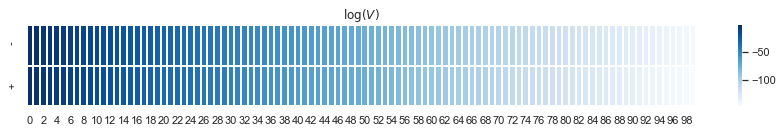

In [21]:
st_vit = hmm.viterbi(seq, transition, emission, init, disp_v=True, disp_alignment=True)

# A refined HMM for CpG Islands

In the previous HMM, the probability of moving into or out of a given state is not dependant on the nucleotide base. This can be rectified by having 8 hidden states: 

1. `a`, `t`, `g` and `c` which represent nucleotides present in **non-CpG islands**

2. `ā`, `ī`, `ō` and `č` which represent nucleotides present in **CpG islands**

The `transition`, `emission` and `init` matrices are as follows.

In [22]:
proto_transition = pd.read_csv("cpg_hmm_2/proto_transition.csv",index_col=0)
emission = pd.read_csv("cpg_hmm_2/emission.csv",index_col=0)
init = pd.read_csv("cpg_hmm_2/init.csv",index_col=0)

### Deriving the Transition Matrix

The `proto_transition` matrix (derived by [Durbin, Eddy, Krogh and Mitchinson in 1998](https://www.semanticscholar.org/paper/Biological-Sequence-Analysis%3A-Probabilistic-Models-Durbin-Eddy/571f5bbecd3a083a2bb6844f59a3f8cea237252e)) has to be modified as shown below with the parameters $1/\delta$ (the expected length of a CpG island) and $1/\tau$ (the expected gap between two CpG islands) to derive the `transition` matrix.

Let $1/\delta = 20$ and $1/\tau = 30$.

In [23]:
delta = 1/20 #average CpG island length is 10
tau = 1/30 #average gap between CpG islands is 20

#derive transition matrix from the proto transition matrix
transition = proto_transition.copy()
transition.iloc[:4,:4] = proto_transition.iloc[:4,:4]*(1-tau)
transition.iloc[4:,4:] = proto_transition.iloc[4:,4:]*(1-delta)
transition.iloc[4:,:4] = proto_transition.iloc[4:,:4]*delta
transition.iloc[:4,4:] = proto_transition.iloc[:4,4:]*tau

In [24]:
transition

,a,c,t,g,ā,č,ī,ō
a,0.290000,0.198167,0.203000,0.275500,0.008333,0.008333,0.008333,0.008333
c,0.311267,0.288067,0.291933,0.075400,0.008333,0.008333,0.008333,0.008333
t,0.239733,0.237800,0.201067,0.288067,0.008333,0.008333,0.008333,0.008333
g,0.171100,0.231033,0.282267,0.282267,0.008333,0.008333,0.008333,0.008333
ā,0.012500,0.012500,0.012500,0.012500,0.171000,0.260300,0.114000,0.404700
č,0.012500,0.012500,0.012500,0.012500,0.162450,0.349600,0.177650,0.260300
ī,0.012500,0.012500,0.012500,0.012500,0.152950,0.322050,0.118750,0.356250
ō,0.012500,0.012500,0.012500,0.012500,0.075050,0.337250,0.172900,0.364800


### Emission Matrix
Since every hidden state can only produce a given nucleotide, the `emission` matrix contains only 1s and 0s.

In [25]:
emission

,A,C,T,G
a,1,0,0,0
c,0,1,0,0
t,0,0,1,0
g,0,0,0,1
ā,1,0,0,0
č,0,1,0,0
ī,0,0,1,0
ō,0,0,0,1


### Init Matrix

In [26]:
init

,a,c,t,g,ā,č,ī,ō
p,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125


### Generating a sequence under the HMM

Let's generate a 100 bp sequence.

In [27]:
st,seq = hmm.generate(transition, emission, init, 100)
print(st)
print(seq)

tatgccacagtgtactgtgcatcačččōīčīčōīčōīāōōččāōōāōčōčāčīčāāōčīččōīīōččččāīōōōōōčōčōōōōīāčtcacagctaaaaaā
TATGCCACAGTGTACTGTGCATCACCCGTCTCGTCGTAGGCCAGGAGCGCACTCAAGCTCCGTTGCCCCATGGGGGCGCGGGGTACTCACAGCTAAAAAA


To simplify visualization, let's map the states `a`, `t`, `g` and `c` to the `-` symbol and states `ā`, `ī`, `ō`, and `č` to the `+` symbol.

In [28]:
def CpGify(state):
    st_cpg = np.array(list(st),dtype='object')
    st_cpg = np.array(np.where((st_cpg=='a')|(st_cpg=='t')|(st_cpg=='c')|(st_cpg=='g'),'-','+'),dtype='object')
    return np.sum(st_cpg)

In [29]:
print(CpGify(st))
print(seq)

------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-------------+
TATGCCACAGTGTACTGTGCATCACCCGTCTCGTCGTAGGCCAGGAGCGCACTCAAGCTCCGTTGCCCCATGGGGGCGCGGGGTACTCACAGCTAAAAAA


### Decoding

Let's decode the sequence we generated above.

In [30]:
st = hmm.viterbi(seq, transition, emission, init)

/Users/shivamchitnis/Documents/computation/bioinfo/HMMs/hmm.py:58: RuntimeWarning: divide by zero encountered in log
  V[:,0] = np.log(init*emission[seq[0]])
/Users/shivamchitnis/Documents/computation/bioinfo/HMMs/hmm.py:63: RuntimeWarning: divide by zero encountered in log
  possibles = V[:,j-1]+np.log(transition.iloc[:,i])+np.log(emission[seq[j]][i])


In [31]:
print(CpGify(st))
print(seq)

------------------------+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++-----------------
TATGCCACAGTGTACTGTGCATCACCCGTCTCGTCGTAGGCCAGGAGCGCACTCAAGCTCCGTTGCCCCATGGGGGCGCGGGGTACTCACAGCTAAAAAA


This model does a good job of identifying CpG rich regions.

# How good is Viterbi?

Let's take sequences of DNA generated under the simple HMM and see what percentage of the hidden states are correctly identified using viterbi.

In [32]:
#get matrices for the simple HMM and set random seed to None
np.random.seed(None)
transition = pd.read_csv("cpg_hmm_1/transition.csv",index_col=0)
emission = pd.read_csv("cpg_hmm_1/emission.csv",index_col=0)
init = pd.read_csv("cpg_hmm_1/init.csv",index_col=0)

In [33]:
N = 100 #sequence length
M = 100 #number of sequences

In [34]:
def performance(M,N,transition,emission,init):
    percent = np.zeros(M)
    for i in range(M):
        st, seq = hmm.generate(transition, emission, init, N)
        st_1 = hmm.viterbi(seq, transition, emission, init)
        check = (np.array(list(st_1)) == np.array(list(st)))
        percent[i] = np.sum(check)/N*100
    return np.mean(percent), np.std(percent)

In [35]:
mean, std = performance(M,N,transition,emission,init)
print("Viterbi accurately identifies: "+str(np.round(mean,2))+" ± "+
      str(np.round(std,2))+" % of the hidden states")

Viterbi accurately identifies: 68.74 ± 13.32 % of the hidden states


## How does this behaviour change with transition and emission probabilities?

Let's define a dishonest casino HMM (with 2 states — $\text{h}$, $\text{d}$ and 2 sequence elements — $\text{H}$, $\text{T}$) with the following properties:

$$P(\text{h|h}) = P(\text{d|d}) = \alpha$$

$$P(\text{H|h}) = P(\text{T|d}) = \beta$$

$$P(\text{h|start}) = P(\text{d|start}) = 1/2$$

Now we scan over $\alpha$ and $\beta$ to see how the viterbi algorithm performs.

In [36]:
states = ['h','d']
elements = ['H','T']

#init matrix is uniform
init = pd.DataFrame(np.array([[0.5,0.5]]),columns = states,index = ['p'])

In [37]:
alpha = np.arange(0.1,1,0.1)
beta = np.arange(0.1,1,0.1)

perf_mn = np.zeros([np.size(alpha),np.size(beta)])
perf_std = np.zeros([np.size(alpha),np.size(beta)])

In [38]:
M = 40 #number of sample sequences
N = 50 #size of each sequence
for i,a in enumerate(alpha):
    for j,b in enumerate(beta):
        transition = pd.DataFrame(np.array([[a,1-a],[1-a,a]]),columns = states, index = states)
        emission = pd.DataFrame(np.array([[b,1-b],[1-b,b]]),columns = elements, index = states)
        perf_mn[i,j],perf_std[i,j] = performance(M,N,transition,emission,init)

### Mean performance as a function of $\alpha$ and $\beta$

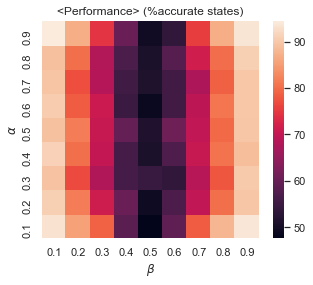

In [39]:
plt.figure(figsize = (5,4))
sns.heatmap(perf_mn, square = True, yticklabels=np.round(alpha,2), xticklabels=np.round(beta,2))
plt.ylim([0,np.size(alpha)]);
plt.ylabel(r"$\alpha$")
plt.xlabel(r"$\beta$")
plt.title("<Performance> (%accurate states)");

When $\beta$ is 0.5, it doesn't really matter what the transition probabilities are — the algorithm performs poorly. As $\beta$ approaches 1 (or equivalently 0), the algorithm performs best for $\alpha$ close to 1 (or equivalently 0). The best performance is for $\alpha \rightarrow 1, \beta \rightarrow 1$.

### Standard deviation of performance as a function of  $\alpha$ and $\beta$

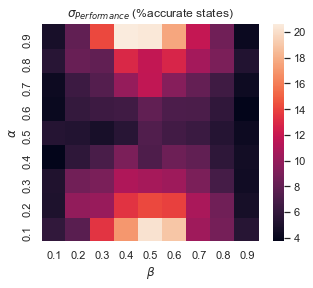

In [40]:
plt.figure(figsize = (5,4))
sns.heatmap(perf_std, square = True, yticklabels=np.round(alpha,2), xticklabels=np.round(beta,2))
plt.ylim([0,np.size(alpha)]);
plt.ylabel(r"$\alpha$")
plt.xlabel(r"$\beta$")
plt.title("$\sigma_{Performance}$ (%accurate states)");

The precision of the algorithm is dependent both on $\alpha$ and $\beta$. It's least precise when $\beta$ is close to 0.5 and $\alpha$ is close to 1 (or equivalently 0). In general, the more random the probabilities become, the less accurate and less precise the viterbi algorithm becomes.